# DA5401 Assignment 4: GMM-Based Synthetic Sampling for Imbalanced Data
### Dataset downloaded as zip and assumed to be present in pwd (Present Working Directory)

### Name: Karan Kishore
### Roll number: DA25D400

### Part A: Data Exploration and Baseline Model
#### A.1 Load and Analyze the dataset
# import necessary libraries

In [65]:
!pip install imblearn

In [66]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"  # Limit OpenBLAS to 1 thread to avoid potential threading issues

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix, roc_auc_score
from sklearn.cluster import KMeans, MiniBatchKMeans
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import seaborn as sns

DATA_PATH = 'creditcard.csv'
df = pd.read_csv(DATA_PATH)

print("Shape of dataset: ", df.shape)
print("Columns in dataset: ", df.columns)


Shape of dataset:  (284807, 31)
Columns in dataset:  Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


In [68]:
print("Class (Fraud/Not Fraud) distribution: \n", df['Class'].value_counts())

Class (Fraud/Not Fraud) distribution: 
 Class
0    284315
1       492
Name: count, dtype: int64


- As we see above, the number of fraud samples is very less (492). The fraction of fraud examples = 492/(284315 + 492) ~ 0.001727 which is roughly 0.1727%.

- 99.8% comprises of non-fraud samples

In [69]:
#df = df.drop(columns=["Time"])
numeric_cols = ["Amount"]
preproc = ColumnTransformer([
    (("scale_amount"), StandardScaler(), numeric_cols)
], remainder="passthrough")
preproc.set_output(transform="pandas")

ColumnTransformer(remainder='passthrough',
                  transformers=[('scale_amount', StandardScaler(), ['Amount'])])

#### A.2 Analyze class distribution

Class distribution in original dataset: 
 Class
0    284315
1       492
Name: count, dtype: int64
Percentage of fraud cases in original dataset: 0.1727%


/tmp/ipython-input-316165858.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = class_counts.index, y = class_counts.values, palette = 'viridis')


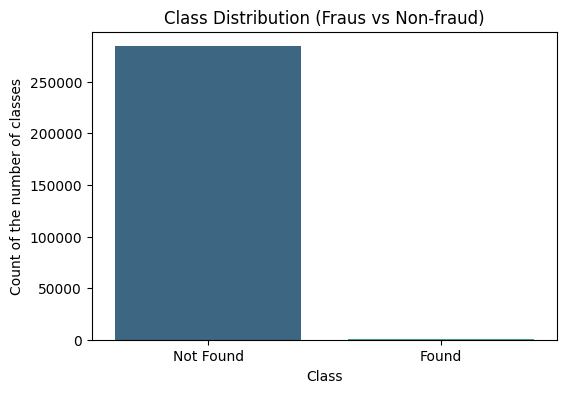

In [70]:
class_counts = df['Class'].value_counts()
print("Class distribution in original dataset: \n", class_counts)

fraud_perc = class_counts[1] / sum(class_counts) * 100
print(f"Percentage of fraud cases in original dataset: {fraud_perc:.4f}%")

plt.figure(figsize = (6,4))
sns.barplot(x = class_counts.index, y = class_counts.values, palette = 'viridis')
plt.xticks([0,1], ['Not Found', 'Found'])
plt.ylabel('Count of the number of classes')
plt.title("Class Distribution (Fraus vs Non-fraud)")
plt.show()

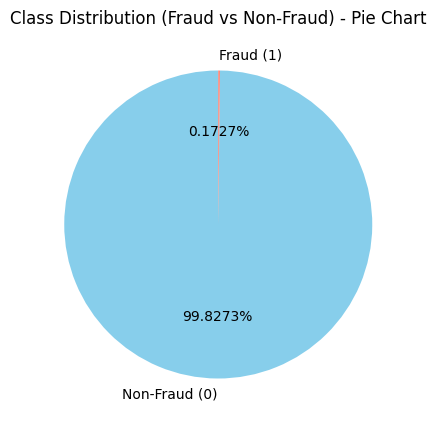

In [71]:
plt.figure(figsize=(5,5))
plt.pie(class_counts, labels=["Non-Fraud (0)", "Fraud (1)"],
        autopct="%1.4f%%", colors=["skyblue", "salmon"], startangle=90)
plt.title("Class Distribution (Fraud vs Non-Fraud) - Pie Chart")
plt.show()

The degree of imbalance is very high. Class named "Fraud" is extremely high occuring as just 0.1727% of the total samples.

#### A.3 Baseline model

In [72]:
df_X = df.drop(columns=["Class"])
df_y = df['Class']


# Use stratify to maintain class distribution in train and test sets as mentioned in the question
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, random_state=42, stratify=df_y)

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

X_train_scaled = pd.DataFrame(
    preproc.fit_transform(X_train),
    columns=preproc.get_feature_names_out(),
    index=X_train.index
).reset_index(drop=True)

X_test_scaled = pd.DataFrame(
    preproc.transform(X_test),
    columns=preproc.get_feature_names_out(),
    index=X_test.index
).reset_index(drop=True)

print("NaNs in training set:", X_train_scaled.isna().sum().sum())
print("NaNs in test set:", X_test_scaled.isna().sum().sum())

#X_train_scaled.rename(columns={"scale_amount__Amount": "Amount"}, inplace=True)
#print(X_train_scaled["Amount"])

NaNs in training set: 0
NaNs in test set: 0


In [73]:
from sklearn.pipeline import Pipeline

baseline_model = Pipeline([
    ("preprocess", preproc),
    ("logreg", LogisticRegression(max_iter=1000, solver='liblinear', random_state=42))
])

baseline_model.fit(X_train, y_train)
y_pred = baseline_model.predict(X_test)

print("\n--- Confusion Matrix ---")
print(confusion_matrix(y_test, y_pred))

print("\n--- Classification Report (focus on class=1) ---")
print(classification_report(y_test, y_pred, digits=4))


--- Confusion Matrix ---
[[85261    34]
 [   51    97]]

--- Classification Report (focus on class=1) ---
              precision    recall  f1-score   support

           0     0.9994    0.9996    0.9995     85295
           1     0.7405    0.6554    0.6953       148

    accuracy                         0.9990     85443
   macro avg     0.8699    0.8275    0.8474     85443
weighted avg     0.9990    0.9990    0.9990     85443



- In the above case, 0 corresponds to non-fraud sample which has a support of 85,295 whereas 1 represents the fraud class with support of just 148 samples.

- Accuracy is very misleading as a very simple model may just learn to predict everything as non-fraud and still have a very high accuracy (99.8273%) which results in the minority class (non-fraud) being completely discarded due to less support (samples).

- The baseline model (**Model 1**) has an accuracy of 99.92% which is very misleading.

- For Fraud class (Class 1), about 85% of transactions predicted as fraud are actually fraud. It catches only 62.16% of total frauds, missing 38% of frauds in a scenario where detecting frauds is very crucial. Here recall is more important than precision to some extent (few non-frauds classified as fraud is okay, but here lot of frauds (more than one-third) are classified as non-frauds which is not acceptable).

### Part B: Gaussian Mixture Model (GMM) for Synthetic Sampling
#### 1. Theoretical Foundation

##### Overall view

**SMOTE**: Generates synthetic samples by interpolating between existing minority class samples and their nearest neighbors by assuming that the local minority region is well approximated by straight-line segments, which may not be true for complex distributions.

**GMM**:
- Generally, minority data lies in multiple disconnected regions. There is no linear interpolation possible between these segments as they have an underlying stricture that needs to be taken care of. We can call these as "sub-populations" within the minority class.
- GMM captures multi-modal structures by fitting multiple Gaussians

##### How new samples are generated
- **SMOTE** generates synthetic points by *linear interpolation* between a minority instance \(x_i\) and one of its \(k\)-nearest neighbors \(x_j\):

$$
x_{\text{new}} = x_i + \lambda (x_j - x_i), \quad \lambda \sim U(0,1)
$$

**Where:**
- \(x_i\) = a minority class sample (vector in feature space)  
- \(x_j\) = one of the \(k\)-nearest neighbors of \(x_i\)  
- \(\lambda\) = a random number from the uniform distribution \(U(0,1)\)  

This forces new samples to lie **on the straight line** between two observed points.


- **GMM-based sampling** assumes the minority data distribution can be modeled as a **mixture of Gaussians**:

$$
p(x) = \sum_{k=1}^K \pi_k \, \mathcal{N}(x \mid \mu_k, \Sigma_k)
$$

**Where:**
- \(K\) = number of Gaussian components  
- \(\pi_k\) = mixing weight of component \(k\), with \(\sum_{k=1}^K \pi_k = 1\)  
- \(\mu_k\) = mean vector of component \(k\)  
- \(\Sigma_k\) = covariance matrix of component \(k\)  
- \(\mathcal{N}(x \mid \mu_k, \Sigma_k)\) = multivariate Gaussian density  

New samples are generated in two steps:
1. Draw component index \(k\) from a categorical distribution with probabilities \(\pi_1, \dots, \pi_K\).  
2. Sample \(x_{\text{new}} \sim \mathcal{N}(\mu_k, \Sigma_k)\).  



##### Multi-modality (sub-groups)
- **SMOTE**: Assumes local linearity within the minority group. It cannot model **multiple disconnected clusters** of minority data.  
  - Example: There can be many examples of cases where there are sub-groups within the minority and some sub-groups may be closer to a majority cluster. In that case, linear interpolation can make boundaries unclear.
- **GMM**: Learns separate Gaussian components for each subgroup. Sampling **respects natural clusters** — no hybrid fraud cases.



##### 3. Density-awareness
- **SMOTE**: Synthetic points are equally likely along interpolation lines → ignores true density of the minority datapoints.  

- **GMM**: New points are generated proportionally to the estimated probability density:

$$
p(x_{\text{new}}) \propto \max_{k} \pi_k \, \mathcal{N}(x_{\text{new}} \mid \mu_k, \Sigma_k)
$$

**Meaning:**  
- Regions of high density in the minority class receive **more synthetic points**.  
- Sparse/low-density regions contribute fewer points.  

This keeps the synthetic dataset aligned with the **empirical likelihood** of the real data.



##### 4. Feature correlations
- **SMOTE**: Works by linear mixing of vectors, which may break natural feature correlations.  
  - Example: In fraud data, `transaction_amount` and `number_of_items` are strongly correlated. SMOTE may generate unrealistic “large amount, few items” samples.  

- **GMM**: The covariance matrix \(\Sigma_k\) of each Gaussian explicitly models feature dependencies. Samples from \(\mathcal{N}(\mu_k, \Sigma_k)\) preserve these correlations.



## 🔹 5. Model interpretability
- **SMOTE**: Purely algorithmic; no explicit probability model. It just takes two points and takes a linear interpolation between them. It does not have an awareness of the data distribution.

- **GMM**: A probabilistic model. It actually preserves the structure of datapoints in the data by capturing the data distribution parameters. We can compute the **log-likelihood** of the training data:

$$
\log p(X \mid \theta) = \sum_{i=1}^N \log \Bigg( \sum_{k=1}^K \pi_k \, \mathcal{N}(x_i \mid \mu_k, \Sigma_k) \Bigg)
$$

**Where:**
- \(X = \{x_1, \dots, x_N\}\) = dataset of \(N\) minority samples  
- \(\theta = \{\pi_k, \mu_k, \Sigma_k\}_{k=1}^K\) = GMM parameters  

We can also choose the best number of components \(K\) using **Bayesian Information Criterion (BIC):**

$$
\text{BIC} = -2 \log L + p \log N
$$

**Where:**
- \(L\) = maximum likelihood of the model  
- \(p\) = number of estimated parameters  
- \(N\) = number of samples  

Lower BIC means a better trade-off between model fit and complexity.



#### Summary
- **SMOTE** → linear interpolation, ignores density, may create unrealistic hybrids, no probabilistic interpretation.  
- **GMM** → statistical generative model, captures clusters (multi-modality), preserves correlations, generates samples proportionally to likelihood, allows model selection (AIC/BIC).  

For imbalanced problems like **fraud detection**, where minority data is **heterogeneous and multi-modal** [Possibility of fraud class], GMM provides more **realistic, theory-driven synthetic samples**.

Overall, SMOTE creates synthetic points by *linear interpolation* between existing minority samples and their nearest neighbours. However, GMM-Based sampling first learns a probabilistic model of the minority class as a Mixture of Gaussians, capturing more clusters and uncertainty in the minority data (in our case).


#### GMM does not disturb the structure of datapoints whereas SMOTE assumes local linearity which may disturb the structure of datapoints in case they are say, **overlapping** majority and minority segments.

(344, 30)
float64
Nan? False
Inf? False
Nulls? 0


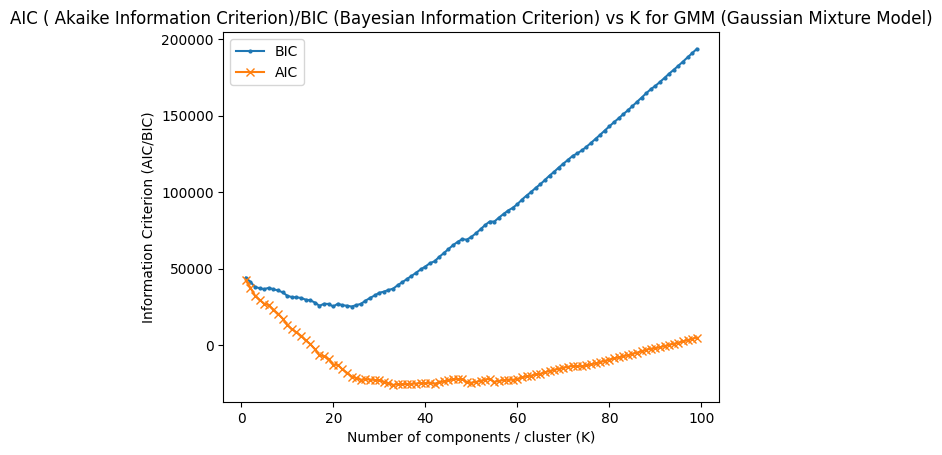

Best K according to BIC: 24
     K           AIC            BIC
0    1  42242.922492   44144.040112
1    2  37483.783764   41289.859646
2    3  32319.625323   38030.659467
3    4  29561.424307   37177.416714
4    5  27094.843720   36615.794389
..  ..           ...            ...
94  95   1618.361197  182585.555451
95  96   2387.671136  185259.823652
96  97   3289.097577  188066.208355
97  98   4118.506799  190800.575839
98  99   4988.639123  193575.666425

[99 rows x 3 columns]


In [78]:
from sklearn.mixture import GaussianMixture

def fit_gmm(X_train, y_train, min_label = 1, k_range = range(1,100), criterion = "bic"):
    X_train = X_train.reset_index(drop = True)
    y_train = y_train.reset_index(drop = True)
    X_min = X_train[y_train == min_label]

    # GMM function needs numpy array as input
    X_minority_np = X_min.values

    print(X_minority_np.shape)
    print(X_minority_np.dtype)

    print("Nan?", np.isnan(X_minority_np).any())
    print("Inf?", np.isinf(X_minority_np).any())
    print("Nulls?", pd.DataFrame(X_minority_np).isnull().sum().sum())

    res = []
    for k in k_range:
        gmm = GaussianMixture(n_components = k, covariance_type = "full", random_state = 42)
        gmm.fit(X_minority_np)

        res.append({
            "K": k,
            "AIC": gmm.aic(X_minority_np),
            "BIC": gmm.bic(X_minority_np)
        })

    results_df = pd.DataFrame(res)

    if criterion == "bic":
        best_k = results_df.loc[results_df["BIC"].idxmin(), "K"]
    else:
        best_k = results_df.loc[results_df["AIC"].idxmin(), "K"]

    best_gmm = GaussianMixture(n_components = int(best_k), covariance_type = "full", random_state = 42)
    best_gmm.fit(X_minority_np)

    plt.plot(results_df["K"], results_df["BIC"], marker = "o", markersize = 2, label = "BIC")
    plt.plot(results_df["K"], results_df["AIC"], marker = "x", label = "AIC")
    plt.xlabel("Number of components / cluster (K)")
    plt.ylabel("Information Criterion (AIC/BIC)")
    plt.title("AIC ( Akaike Information Criterion)/BIC (Bayesian Information Criterion) vs K for GMM (Gaussian Mixture Model) on minority data")
    plt.legend()
    plt.show()

    print("Best K according to {}: {}".format(criterion.upper(), best_k))

    return best_gmm, results_df

best_gmm, results = fit_gmm(X_train, y_train, min_label = 1)

print(results)

### Using BIC, the curve of BIC vs K reaches minimum around 24. After that, increasing clusters doesn't reduce BIC. AIC also flattens around K = 24. So, reduce the complexity by increasing the number of clusters (Taking a higher K has very less reduction on AIC), we take K = 24.

In [43]:
from collections import Counter
n_to_generate = int((len(X_train[y_train == 0]) - len(X_train[y_train == 1])))
print("Number of samples required to balance the dataset: ", n_to_generate)

synthetic_samples, _ = best_gmm.sample(n_to_generate)

# Combine synthetic and real samples
X_full = np.vstack([X_train, synthetic_samples])
y_full = np.concatenate([y_train, np.ones(n_to_generate, dtype = int)]) # Rest of the datapoints belong to class 1 [Fraud]

print("Class distribtuion after combining with synthetic samples generated using fitted Gaussian Mixture Model (GMM): ")
class_names = {0: "Not fraud", 1: "Fraud"}
for category, count in Counter(y_full).items():
  print(f" Class: {class_names[category]:^10}, Number of samples: {count:^10}")


Number of samples required to balance the dataset:  198676
Class distribtuion after combining with synthetic samples generated using fitted Gaussian Mixture Model (GMM): 
 Class: Not fraud , Number of samples:   199020  
 Class:   Fraud   , Number of samples:   199020  


# Sampling from a Gaussian Mixture Model (GMM)

## What is a Gaussian Mixture Model (GMM)?

A Gaussian Mixture Model assumes the probability density of the data $x \in \mathbb{R}^d$ is a weighted sum of $K$ Gaussian (normal) components:

$$
p(x) = \sum_{k=1}^K \pi_k\,\mathcal{N}(x \mid \mu_k, \Sigma_k),
\qquad
\text{where } \sum_{k=1}^K \pi_k = 1,\; \pi_k \ge 0.
$$

- $\pi_k$ is the *mixing weight* (probability) of component $k$.  
- $\mu_k \in \mathbb{R}^d$ is the mean vector of component $k$.  
- $\Sigma_k \in \mathbb{R}^{d \times d}$ is the covariance matrix of component $k$.  
- $\mathcal{N}(x \mid \mu, \Sigma)$ denotes the multivariate normal density.

A fitted GMM gives you the tuple $\{(\pi_k, \mu_k, \Sigma_k)\}_{k=1}^K$.

---

## Intuition for sampling

Sampling from the mixture means sampling first *which Gaussian* to draw from, then sampling a point from that Gaussian. This preserves both the within-component shape (via $\mu_k, \Sigma_k$) and the component proportions (via $\pi_k$).

---

## Exact algorithm (step-by-step)

To draw $N$ synthetic samples from a fitted GMM:

1. **Selecting the $k^{\text{th}}$ Gaussian**  
   For each synthetic sample $i = 1, \dots, N$ choose a component index $z_i \in \{1,\dots,K\}$ by sampling from the categorical distribution defined by $\pi = (\pi_1,\dots,\pi_K)$:

   $$
   P(z_i = k) = \pi_k.
   $$

2. **Within-component sampling (multivariate normal).**  
   For each component $k$, draw $n_k$ independent samples from

   $$
   x \sim \mathcal{N}(\mu_k, \Sigma_k).
   $$

   Implementation note: to sample a vector from $\mathcal{N}(\mu_k, \Sigma_k)$ you can use a Cholesky factorization $\Sigma_k = L_k L_k^\top$ and compute

   $$
   x = \mu_k + L_k\,\varepsilon,\quad \varepsilon \sim \mathcal{N}(0, I_d).
   $$

3. **Concatenate the sampled points and shuffle (optional)**  
   Stack all the generated samples from all components into an $N \times d$ array. Optionally shuffle the rows.


## Other details

- **Number of components $K$:** Chosen here from using Bayesian Information Criterion (BIC)  
- **Covariance type:** `full` allows full covariance matrices    

## How many samples to generate to balance the dataset?

If you have $M$ majority and $m$ minority training samples, generate:

$$
N = M - m
$$

synthetic minority samples (or a fraction if intermediate ratio is considered).

# Inertia and Silhouette Score

## Inertia (Within-Cluster Sum of Squares, WCSS)

**Definition:**  
Inertia measures how tightly the data points are grouped within each cluster.  
It is the sum of squared distances between each point and the centroid of the cluster it belongs to.  
Lower values indicate denser, more compact clusters.

**Formula:**

$$
\text{Inertia} = \sum_{k=1}^{K} \sum_{x_i \in C_k} \lVert x_i - \mu_k \rVert^2
$$

**Where:**
- $K$ = number of clusters  
- $C_k$ = set of points in cluster $k$  
- $x_i$ = data point  
- $\mu_k$ = centroid of cluster $k$  
- $\lVert \cdot \rVert$ = Euclidean distance  


## Silhouette Score

**Definition:**  
Silhouette score measures how well-separated and cohesive clusters are.  
It combines **cohesion** (how close a point is to its own cluster) and **separation** (how far it is from other clusters).  

Values range between **-1 and +1**:  
- **+1** → well-clustered  
- **0** → overlapping clusters  
- **-1** → misclassified points  

**Formula for a single point \(i\):**

$$
s(i) = \frac{b(i) - a(i)}{\max \{a(i), b(i)\}}
$$

**Where:**
- \(a(i)\) = average distance of point \(i\) to all other points in the same cluster (**cohesion**)  
- \(b(i)\) = minimum average distance of point \(i\) to points in another cluster (**separation**)  

---

**Overall Silhouette Score:**

$$
S = \frac{1}{n} \sum_{i=1}^{n} s(i)
$$

**Where:**
- \(n\) = total number of data points  



**Comparison:**  
- **Inertia** → absolute measure, decreases as \(K\) increases (scale-dependent).  
- **Silhouette** → relative, normalized score that balances cohesion and separation.





Since number of samples in majority (Non-Fraud) class is very large, use MiniBatchKMeans to find a K that is good enough for clusterig while maintaining the rich distribution characteristics.

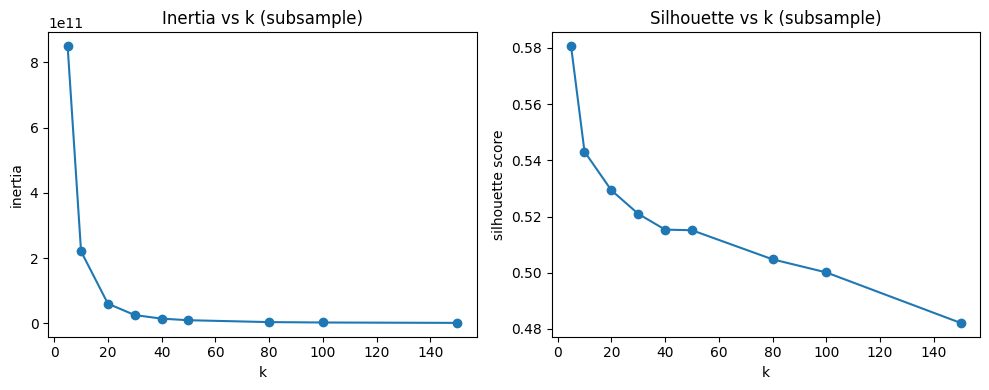

In [44]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

def choose_k_via_subsample(X_majority, k_candidates = None, subsample_size = 20000, pca_dims = 20, random_state = 42):
  rng = np.random.default_rng(random_state)
  n = len(X_majority)
  sample_idx = rng.choice(n, size=min(subsample_size, n), replace = False)
  X_sub = np.array(X_majority)[sample_idx]

  if pca_dims is not None and pca_dims < X_sub.shape[1]:
    pca = PCA(n_components = pca_dims, random_state = random_state)
    X_sub_p = pca.fit_transform(X_sub)
  else:
    X_sub_p = X_sub

  if k_candidates is None:
        # a reasonable sweep: small to moderately large k
        k_candidates = list(range(5, 51, 5)) + list(range(60, 201, 20))

  inertias = []
  silhouettes = []

  for k in k_candidates:
    mbkm = MiniBatchKMeans(n_clusters = k, random_state=random_state, batch_size = 1024, n_init = 5)
    labels = mbkm.fit_predict(X_sub_p)
    inertias.append(mbkm.inertia_)

    if len(X_sub_p) > 5000:
      s_idx = rng.choice(len(X_sub_p), size = 5000, replace = False)
      sil = silhouette_score(X_sub_p, labels)
    else:
      sil = silhouette_score(X_sub_p, labels)
    silhouettes.append(sil)

    results = {
      "k_candidates": k_candidates,
      "inertia": inertias,
      "silhouette": silhouettes,
      "X_sub": X_sub,        # keep for plotting if needed
      "X_sub_reduced": X_sub_p
  }
  return results

res = choose_k_via_subsample(X_train[y_train == 0],
                             k_candidates=[5,10,20,30,40,50,80,100,150],
                             subsample_size=10000,
                             pca_dims=20,
                             random_state=42)

ks = res["k_candidates"]
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(ks, res["inertia"], marker='o')
plt.title("Inertia vs k (subsample)")
plt.xlabel("k"); plt.ylabel("inertia")

plt.subplot(1,2,2)
plt.plot(ks, res["silhouette"], marker='o')
plt.title("Silhouette vs k (subsample)")
plt.xlabel("k"); plt.ylabel("silhouette score")
plt.tight_layout()
plt.show()


K = 20 is a sweet spot between inertia and silhoutte. Lower inertia means that points are close to their centroids and the elbow is arounf k = 20. For Silhouette, higher values implies better separation and compactness.

## Initally, we have a 0.17% proportion for the minority datapoints. So the proportion is around 1:1000. We take a reasonable downsampling to maintain a ratio of 1:100. We'll test this against 1:50 as well just to check if there is any difference in the performance. This is important as 1:1 ratio makes the dataset too small (just like 344 majority from a ~1,99,000 doesn't loses a lot of information).

In [81]:
## initally, we have a 0.17% proportion for the minority datapoints. So the proportion is around 1:1000. We take a reasonable downsampling to maintain a ratio of 1:100. We'll test this against 1:50 as well just to check if there is any difference in the performance. This is important as 1:1 ratio makes the

In [87]:
def cbu(X_train, y_train, k = 20, random_state = 42, ratio = 100):
  X_train = X_train.values
  y_train = y_train.values

  X_min = X_train[y_train == 1]
  X_maj = X_train[y_train == 0]

  # How many majority points to keep = same as minority
  target_majority = int(len(X_min) * ratio)

  # If majority already small enough → nothing to do
  if target_majority >= len(X_maj):
      return X_train.copy(), y_train.copy()

  # Cluster the majority
  kmeans = KMeans(n_clusters=k, random_state=random_state, n_init="auto")
  labels = kmeans.fit_predict(X_maj)

  X_maj_new = []
  # Sample proportionally from each cluster
  for c in range(k):
      cluster_points = X_maj[labels == c]
      if len(cluster_points) == 0:
          continue
      n_take = int(target_majority * len(cluster_points) / len(X_maj))
      if n_take > 0:
          idx = np.random.choice(len(cluster_points), size=n_take, replace=False)
          X_maj_new.append(cluster_points[idx])

  X_maj_sel = np.vstack(X_maj_new)

  # Combine minority and reduced majority
  X_new = np.vstack([X_min, X_maj_sel])
  y_new = np.concatenate([
      np.ones(len(X_min), dtype=int),
      np.zeros(len(X_maj_sel), dtype=int)
  ])

  return X_new, y_new

X_cbu_100, y_cbu_100 = cbu(X_train, y_train, k=20, random_state=42)
X_cbu_50, y_cbu_50 = cbu(X_train, y_train, k = 20, random_state = 42, ratio = 50)
X_cbu_25, y_cbu_25 = cbu(X_train, y_train, k = 20, random_state = 42, ratio = 25)
X_cbu_10, y_cbu_10 = cbu(X_train, y_train, k = 20, random_state = 42, ratio = 10)
print("Original class counts [(Class 0: Non fraud), (Class 1: Fraud)]:", np.bincount(y_train))
print("Class counts after using 1:100 minority:majority ratio [(Class 0: Non fraud), (Class 1: Fraud)]::", np.bincount(y_cbu_100))
print("Class counts after using 1:50 minority:majority ratio [(Class 0: Non fraud), (Class 1: Fraud)]::", np.bincount(y_cbu_50))
print("Class counts after using 1:25 minority:majority ratio [(Class 0: Non fraud), (Class 1: Fraud)]::", np.bincount(y_cbu_25))
print("Class counts after using 1:10 minority:majority ratio [(Class 0: Non fraud), (Class 1: Fraud)]::", np.bincount(y_cbu_10))


Original class counts [(Class 0: Non fraud), (Class 1: Fraud)]: [199020    344]
Class counts after using 1:100 minority:majority ratio [(Class 0: Non fraud), (Class 1: Fraud)]:: [34388   344]
Class counts after using 1:50 minority:majority ratio [(Class 0: Non fraud), (Class 1: Fraud)]:: [17188   344]
Class counts after using 1:25 minority:majority ratio [(Class 0: Non fraud), (Class 1: Fraud)]:: [8590  344]
Class counts after using 1:10 minority:majority ratio [(Class 0: Non fraud), (Class 1: Fraud)]:: [3430  344]


Use GMM to synthetically generate datapoints to match the majority samples undersampled using CBU (Clustering Based Undersampling). This should be hopefully better than oversampling to match original majority (rather than the one downsampled by CBU).

Technically, CBO (Clustering based Oversampling) doesn't introduce any new information whereas CBU (Clustering Based Undersampling) actually tries to undersample points within a cluster (doesn't lose information, but still reduces redundant data). Redundant data may form extra clusters if not handled properly, in that way CBU can perform better on the majority data.

In [89]:
def gmm_oversample(X_min, target_size, n_components = 24, random_state = 42): # K = 24 is obtained from the AIC/BIC plots on minority class
  gmm = GaussianMixture(n_components = n_components, random_state = random_state)
  gmm.fit(X_min)

  n_generate = target_size - len(X_min)
  if n_generate <= 0:
    return X_min.copy()

  X_synthetic, _ = gmm.sample(n_generate)
  X_balanced_min = np.vstack([X_min, X_synthetic])
  return X_balanced_min

target_minority = len(X_cbu_100[y_cbu_100 == 0]) # The number of majority samples after CBU
X_min_balanced = gmm_oversample(X_train[y_train == 1], target_minority, n_components = 5)

X_gmm_2_100 = np.vstack([X_min_balanced, X_cbu_100[y_cbu_100 == 0]])
y_gmm_2_100 = np.concatenate([
    np.ones(len(X_min_balanced), dtype=int),
    np.zeros(len(X_cbu_100[y_cbu_100 == 0]), dtype=int)
])

target_minority = len(X_cbu_50[y_cbu_50 == 0]) # The number of majority samples after CBU
X_min_balanced = gmm_oversample(X_train[y_train == 1], target_minority, n_components = 5)

X_gmm_2_50 = np.vstack([X_min_balanced, X_cbu_50[y_cbu_50 == 0]])
y_gmm_2_50 = np.concatenate([
    np.ones(len(X_min_balanced), dtype=int),
    np.zeros(len(X_cbu_50[y_cbu_50 == 0]), dtype=int)
])

target_minority = len(X_cbu_25[y_cbu_25 == 0]) # The number of majority samples after CBU
X_min_balanced = gmm_oversample(X_train[y_train == 1], target_minority, n_components = 5)

X_gmm_2_25 = np.vstack([X_min_balanced, X_cbu_25[y_cbu_25 == 0]])
y_gmm_2_25 = np.concatenate([
    np.ones(len(X_min_balanced), dtype=int),
    np.zeros(len(X_cbu_25[y_cbu_25 == 0]), dtype=int)
])

target_minority = len(X_cbu_10[y_cbu_10 == 0]) # The number of majority samples after CBU
X_min_balanced = gmm_oversample(X_train[y_train == 1], target_minority, n_components = 5)

X_gmm_2_10 = np.vstack([X_min_balanced, X_cbu_10[y_cbu_10 == 0]])
y_gmm_2_10 = np.concatenate([
    np.ones(len(X_min_balanced), dtype=int),
    np.zeros(len(X_cbu_10[y_cbu_10 == 0]), dtype=int)
])

print("Balanced counts using a 1:100 ratio for minority:majority:", np.bincount(y_gmm_2_100))
print("Balanced counts using a 1:50 ratio for minority:majority:", np.bincount(y_gmm_2_50))
print("Balanced counts using a 1:25 ratio for minority:majority:", np.bincount(y_gmm_2_25))
print("Balanced counts using a 1:10 ratio for minority:majority:", np.bincount(y_gmm_2_10))

Balanced counts using a 1:100 ratio for minority:majority: [34388 34388]
Balanced counts using a 1:50 ratio for minority:majority: [17188 17188]
Balanced counts using a 1:25 ratio for minority:majority: [8590 8590]
Balanced counts using a 1:10 ratio for minority:majority: [3430 3430]


### Part C: Performance Evaluation and Conclusion

#### C.1 Model Training and Evaluation

In [90]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def train_evaluate_lr(X_train, y_train, X_test, y_test, model_version):
  lr = Pipeline([
        ('scaler', StandardScaler(with_mean=False)),
        ('lr', LogisticRegression(max_iter=1000, random_state=42, class_weight = "balanced"))
    ])
  lr.fit(X_train, y_train)
  y_pred = lr.predict(X_test)

  ver_info = {0: "GMM based synthetic sampling for minority class (Fraud)", 1: "CBU on Majority class (Non-fraud) and GMM synthetic sampling for Minority (Fraud) [1:100 class ratio]", 2: "CBU on Majority class (Non-fraud) and GMM synthetic sampling for Minority (Fraud) [1:50 class ratio]", 3: "CBU on Majority class (Non-fraud) and GMM synthetic sampling for Minority (Fraud) [1:25 class ratio]", 4:"CBU on Majority class (Non-fraud) and GMM synthetic sampling for Minority (Fraud) [1:10 class ratio]"}

  acc = accuracy_score(y_test, y_pred)
  report = classification_report(y_test, y_pred, digits = 4, output_dict = True)
  print(f"Logistic Regression Performance for {ver_info[model_version]}")
  print(f"Accuracy: {acc:.4f}")
  print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
  print("Classification Report:\n", classification_report(y_test, y_pred, digits = 4))
  print("\n")

  # Get the metric for class 1 (minority) to be reported later
  return lr, {
      "accuracy": acc,
      "precision": report["1"]["precision"],
      "recall": report["1"]["recall"],
      "f1": report["1"]["f1-score"]
  }

lr_model1, metrics1 = train_evaluate_lr(X_full, y_full, X_test, y_test, 0)
lr_model2_100, metrics2_100 = train_evaluate_lr(X_gmm_2_100, y_gmm_2_100, X_test, y_test, 1) # 1:100 class ratio
lr_model2_50, metrics2_50 = train_evaluate_lr(X_gmm_2_50, y_gmm_2_50, X_test, y_test, 2) # 1:50 class ratio
lr_model2_25, metrics2_25 = train_evaluate_lr(X_gmm_2_25, y_gmm_2_25, X_test, y_test, 3) # 1:25 class ratio
lr_model2_10, metrics2_10 = train_evaluate_lr(X_gmm_2_10, y_gmm_2_10, X_test, y_test, 4) # 1:10 class ratio


baseline_model = Pipeline([
    ("preprocess", preproc),
    ("logreg", LogisticRegression(max_iter=1000, solver='liblinear', random_state=42))
])

baseline_model.fit(X_train, y_train)
y_pred = baseline_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, digits = 4, output_dict = True)
metrics3 = {
    "accuracy": acc,
    "precision": report["1"]["precision"],
    "recall": report["1"]["recall"],
    "f1": report["1"]["f1-score"]
}
print("\n--- Confusion Matrix ---")
print(confusion_matrix(y_test, y_pred))

print("\n--- Classification Report (focus on class=1) ---")
print(classification_report(y_test, y_pred, digits=4))

#baseline_model, metrics3 = train_evaluate_lr(X_train_scaled, y_train, X_test_scaled, y_test, 2)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Logistic Regression Performance for GMM based synthetic sampling for minority class (Fraud)
Accuracy: 0.9823
Confusion Matrix:
 [[83804  1491]
 [   21   127]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9997    0.9825    0.9911     85295
           1     0.0785    0.8581    0.1438       148

    accuracy                         0.9823     85443
   macro avg     0.5391    0.9203    0.5674     85443
weighted avg     0.9982    0.9823    0.9896     85443





/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Logistic Regression Performance for CBU on Majority class (Non-fraud) and GMM synthetic sampling for Minority (Fraud) [1:100 class ratio]
Accuracy: 0.9795
Confusion Matrix:
 [[83563  1732]
 [   21   127]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9997    0.9797    0.9896     85295
           1     0.0683    0.8581    0.1266       148

    accuracy                         0.9795     85443
   macro avg     0.5340    0.9189    0.5581     85443
weighted avg     0.9981    0.9795    0.9881     85443





/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Logistic Regression Performance for CBU on Majority class (Non-fraud) and GMM synthetic sampling for Minority (Fraud) [1:50 class ratio]
Accuracy: 0.9803
Confusion Matrix:
 [[83637  1658]
 [   22   126]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9997    0.9806    0.9901     85295
           1     0.0706    0.8514    0.1304       148

    accuracy                         0.9803     85443
   macro avg     0.5352    0.9160    0.5602     85443
weighted avg     0.9981    0.9803    0.9886     85443



Logistic Regression Performance for CBU on Majority class (Non-fraud) and GMM synthetic sampling for Minority (Fraud) [1:25 class ratio]
Accuracy: 0.9787
Confusion Matrix:
 [[83500  1795]
 [   21   127]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9997    0.9790    0.9892     85295
           1     0.0661    0.8581    0.1227       148

    accuracy                         0.9787     854

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(



--- Confusion Matrix ---
[[85261    34]
 [   51    97]]

--- Classification Report (focus on class=1) ---
              precision    recall  f1-score   support

           0     0.9994    0.9996    0.9995     85295
           1     0.7405    0.6554    0.6953       148

    accuracy                         0.9990     85443
   macro avg     0.8699    0.8275    0.8474     85443
weighted avg     0.9990    0.9990    0.9990     85443



For Model 1 (GMM-full with minority class oversampling using GMM to equal to majority class samples), the precision and recall for class 1 (Fraud) is 0.0755 and 0.8716 respectively.

This shows that the recall has increased from around 65.54% to 87.16%, more than 20% increase. So, GMM based oversampling indeed helps improve the model capability on the minority data, but at the cost of reduction in precision. In case of credit frauds, the False Negative is very important as we don't want to ignore fradulent transactions. The precision is lesser as there are many synthetic samples of Fraud examples. This could be due to the fact that X_test has much fewer samples of class 1 (Support is just 148 compared to 85,295), but the X_train has equal number of both the classes.

Hence, GMM-based oversampling definitely helps improve the detection of minority class (Fraud examples).

Now, let's look at the metric visually with the help of a bar chart for each of the three models.

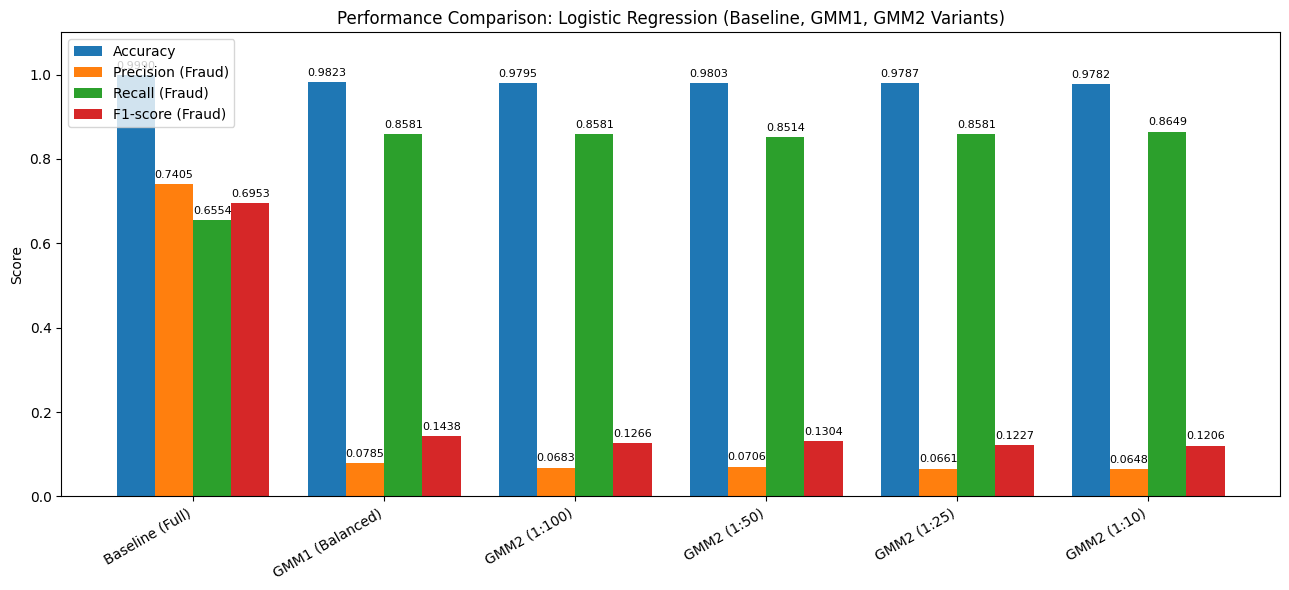

In [93]:
import matplotlib.pyplot as plt
import numpy as np

# Model names
models = [
    "Baseline (Full)",
    "GMM1 (Balanced)",
    "GMM2 (1:100)",
    "GMM2 (1:50)",
    "GMM2 (1:25)",
    "GMM2 (1:10)"
]

# Descriptions if needed
models_desc = [
    "Baseline LR trained on full imbalanced dataset",
    "LR with GMM1 oversampling to match majority",
    "LR with GMM2 oversampling at 1:100 ratio",
    "LR with GMM2 oversampling at 1:50 ratio",
    "LR with GMM2 oversampling at 1:25 ratio",
    "LR with GMM2 oversampling at 1:10 ratio"
]

# Metrics
accuracies = [
    metrics3["accuracy"],
    metrics1["accuracy"],
    metrics2_100["accuracy"],
    metrics2_50["accuracy"],
    metrics2_25["accuracy"],
    metrics2_10["accuracy"]
]

precisions = [
    metrics3["precision"],
    metrics1["precision"],
    metrics2_100["precision"],
    metrics2_50["precision"],
    metrics2_25["precision"],
    metrics2_10["precision"]
]

recalls = [
    metrics3["recall"],
    metrics1["recall"],
    metrics2_100["recall"],
    metrics2_50["recall"],
    metrics2_25["recall"],
    metrics2_10["recall"]
]

f1s = [
    metrics3["f1"],
    metrics1["f1"],
    metrics2_100["f1"],
    metrics2_50["f1"],
    metrics2_25["f1"],
    metrics2_10["f1"]
]

# Plot setup
x = np.arange(len(models))
width = 0.2

fig, ax = plt.subplots(figsize=(13,6))
rects1 = ax.bar(x - 1.5*width, accuracies, width, label="Accuracy")
rects2 = ax.bar(x - 0.5*width, precisions, width, label="Precision (Fraud)")
rects3 = ax.bar(x + 0.5*width, recalls, width, label="Recall (Fraud)")
rects4 = ax.bar(x + 1.5*width, f1s, width, label="F1-score (Fraud)")

# Labels and formatting
ax.set_ylabel("Score")
ax.set_title("Performance Comparison: Logistic Regression (Baseline, GMM1, GMM2 Variants)")
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=30, ha="right")
ax.legend()
ax.set_ylim(0, 1.1)

# Annotate bars with values
for rects in [rects1, rects2, rects3, rects4]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


## Let us try finetuning the logistic regression model for different thresholds so that we get a better classifier as precision is very low.

In [109]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_recall_fscore_support,
    f1_score,
    precision_score,
    recall_score
)

def train_evaluate_lr(X_train, y_train, X_test, y_test, model_version, step = 0.05): # Step is used to search for the best threshold for Logistic Regressor
  lr = Pipeline([
        ('scaler', StandardScaler(with_mean=False)),
        ('lr', LogisticRegression(max_iter=1000, random_state=42, class_weight = "balanced", C = 0.1))
    ])
  lr.fit(X_train, y_train)
  # Probabilities instead of hard predictions
  y_prob = lr.predict_proba(X_test)[:, 1]  # probability of class 1 (fraud)

  # Threshold search
  thresholds = np.arange(0.05, 1.0, step)
  best_thresh, best_f1, best_prec = 0.5, -1, -1
  metrics_at_best = None

  for thresh in thresholds:
      y_pred_thresh = (y_prob >= thresh).astype(int)
      precision, recall, f1, _ = precision_recall_fscore_support(
          y_test, y_pred_thresh, average=None, labels=[1]
      )

      precision_weighted = precision_score(y_test, y_pred_thresh, average="weighted")
      recall_weighted = recall_score(y_test, y_pred_thresh, average="weighted")
      f1_weighted = f1_score(y_test, y_pred, average = "weighted") # Use weighted f1 for averaging across the classes (better estimate)
      if precision_weighted > best_prec:
          best_prec = precision_weighted
          best_thresh = thresh
          metrics_at_best = {
              "accuracy": accuracy_score(y_test, y_pred_thresh),
              "precision": precision[0],
              "recall": recall[0],
              "f1": f1[0],
              "f1_weighted": f1_weighted,
              "threshold": best_thresh,
              "precision_weighted": precision_weighted,
              "recall_weighted": recall_weighted,
              "f1_weighted": f1_weighted,
          }

  print(f"🔎 Best threshold = {best_thresh:.2f} with precision = {best_prec:.4f}")
  print("Confusion Matrix:\n", confusion_matrix(y_test, (y_prob >= best_thresh).astype(int)))
  print("Classification Report:\n", classification_report(y_test, (y_prob >= best_thresh).astype(int), digits=4))

  return lr, metrics_at_best

lr_model1, metrics1 = train_evaluate_lr(X_full, y_full, X_test, y_test, 0)
lr_model2_100, metrics2_100 = train_evaluate_lr(X_gmm_2_100, y_gmm_2_100, X_test, y_test, 1) # 1:100 class ratio
lr_model2_50, metrics2_50 = train_evaluate_lr(X_gmm_2_50, y_gmm_2_50, X_test, y_test, 2) # 1:50 class ratio
lr_model2_25, metrics2_25 = train_evaluate_lr(X_gmm_2_25, y_gmm_2_25, X_test, y_test, 3) # 1:25 class ratio
lr_model2_10, metrics2_10 = train_evaluate_lr(X_gmm_2_10, y_gmm_2_10, X_test, y_test, 4) # 1:10 class ratio


baseline_model = Pipeline([
    ("preprocess", preproc),
    ("logreg", LogisticRegression(max_iter=1000, solver='liblinear', random_state=42))
])

baseline_model.fit(X_train, y_train)
y_pred = baseline_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, digits = 4, output_dict = True)
metrics3 = {
    "accuracy": acc,
    "precision": report["1"]["precision"],
    "recall": report["1"]["recall"],
    "f1": report["1"]["f1-score"],
    "f1_weighted": report["weighted avg"]["f1-score"],
    "precision_weighted": report["weighted avg"]["precision"],
    "recall_weighted": report["weighted avg"]["recall"]
}
print("\n--- Confusion Matrix ---")
print(confusion_matrix(y_test, y_pred))

print("\n--- Classification Report (focus on class=1) ---")
print(classification_report(y_test, y_pred, digits=4))

#baseline_model, metrics3 = train_evaluate_lr(X_train_scaled, y_train, X_test_scaled, y_test, 2)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


🔎 Best threshold = 0.95 with precision = 0.9989
Confusion Matrix:
 [[85206    89]
 [   29   119]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9997    0.9990    0.9993     85295
           1     0.5721    0.8041    0.6685       148

    accuracy                         0.9986     85443
   macro avg     0.7859    0.9015    0.8339     85443
weighted avg     0.9989    0.9986    0.9987     85443



/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


🔎 Best threshold = 0.95 with precision = 0.9988
Confusion Matrix:
 [[85187   108]
 [   33   115]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9996    0.9987    0.9992     85295
           1     0.5157    0.7770    0.6199       148

    accuracy                         0.9983     85443
   macro avg     0.7577    0.8879    0.8096     85443
weighted avg     0.9988    0.9983    0.9985     85443



/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


🔎 Best threshold = 0.95 with precision = 0.9989
Confusion Matrix:
 [[85212    83]
 [   34   114]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9996    0.9990    0.9993     85295
           1     0.5787    0.7703    0.6609       148

    accuracy                         0.9986     85443
   macro avg     0.7891    0.8846    0.8301     85443
weighted avg     0.9989    0.9986    0.9987     85443



/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


🔎 Best threshold = 0.95 with precision = 0.9987
Confusion Matrix:
 [[85189   106]
 [   37   111]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9996    0.9988    0.9992     85295
           1     0.5115    0.7500    0.6082       148

    accuracy                         0.9983     85443
   macro avg     0.7555    0.8744    0.8037     85443
weighted avg     0.9987    0.9983    0.9985     85443



/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


🔎 Best threshold = 0.95 with precision = 0.9988
Confusion Matrix:
 [[85208    87]
 [   39   109]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9995    0.9990    0.9993     85295
           1     0.5561    0.7365    0.6337       148

    accuracy                         0.9985     85443
   macro avg     0.7778    0.8677    0.8165     85443
weighted avg     0.9988    0.9985    0.9986     85443


--- Confusion Matrix ---
[[85261    34]
 [   51    97]]

--- Classification Report (focus on class=1) ---
              precision    recall  f1-score   support

           0     0.9994    0.9996    0.9995     85295
           1     0.7405    0.6554    0.6953       148

    accuracy                         0.9990     85443
   macro avg     0.8699    0.8275    0.8474     85443
weighted avg     0.9990    0.9990    0.9990     85443



## As threshold increases, precision increases by recall decreases.

In the above plot,

1. GMM-1 is the logistic regression model whose dataset is obtained using Minority Class oversampling using GMM to match the number of majority samples.

2. GMM-2 is the logistic regression model whose dataset is obtained using CBU on Majority dataset and then GMM based oversampling of minority class to reach the majority class.

3. Baseline model is the logistic regression model trained on imbalanced training data.



LDA - understanding data goodness.
ftu for lr_model
gmm1 has low weightage, the evaluation has been done holistically for both class. average has also been analysed.

In [94]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

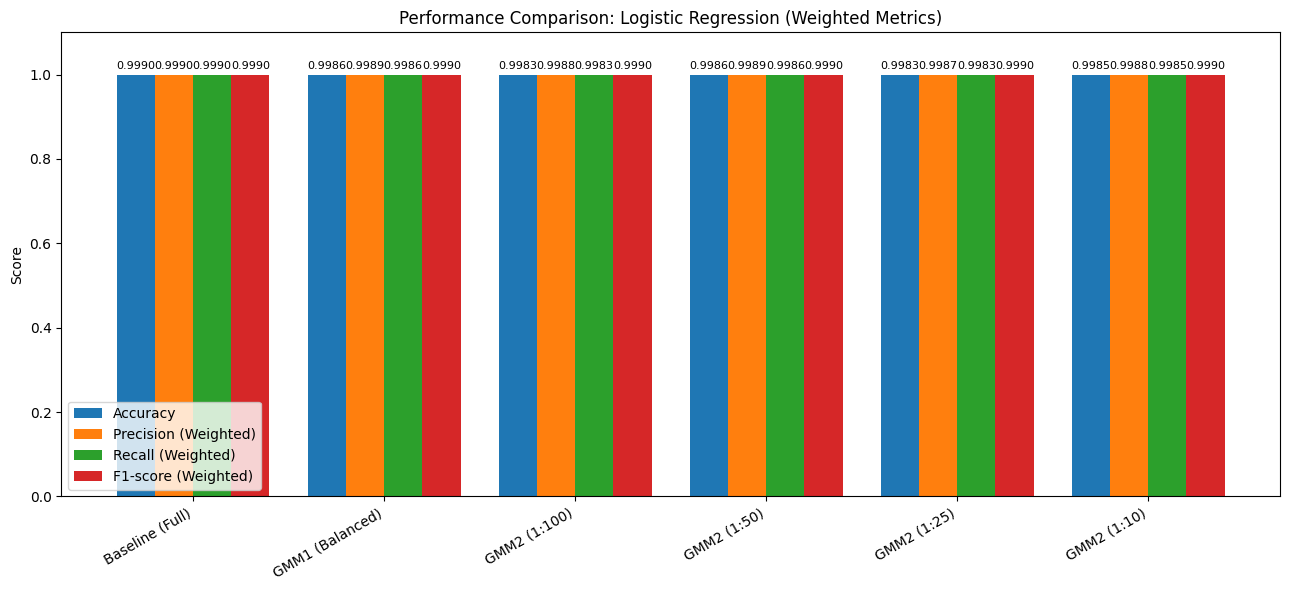

In [107]:
import matplotlib.pyplot as plt
import numpy as np

# Model names
models = [
    "Baseline (Full)",
    "GMM1 (Balanced)",
    "GMM2 (1:100)",
    "GMM2 (1:50)",
    "GMM2 (1:25)",
    "GMM2 (1:10)"
]

# Metrics (weighted versions)
accuracies = [
    metrics3["accuracy"],
    metrics1["accuracy"],
    metrics2_100["accuracy"],
    metrics2_50["accuracy"],
    metrics2_25["accuracy"],
    metrics2_10["accuracy"]
]

precisions_w = [
    metrics3["precision_weighted"],
    metrics1["precision_weighted"],
    metrics2_100["precision_weighted"],
    metrics2_50["precision_weighted"],
    metrics2_25["precision_weighted"],
    metrics2_10["precision_weighted"]
]

recalls_w = [
    metrics3["recall_weighted"],
    metrics1["recall_weighted"],
    metrics2_100["recall_weighted"],
    metrics2_50["recall_weighted"],
    metrics2_25["recall_weighted"],
    metrics2_10["recall_weighted"]
]

f1s_w = [
    metrics3["f1_weighted"],
    metrics1["f1_weighted"],
    metrics2_100["f1_weighted"],
    metrics2_50["f1_weighted"],
    metrics2_25["f1_weighted"],
    metrics2_10["f1_weighted"]
]

# Plot setup
x = np.arange(len(models))
width = 0.2

fig, ax = plt.subplots(figsize=(13,6))
rects1 = ax.bar(x - 1.5*width, accuracies, width, label="Accuracy")
rects2 = ax.bar(x - 0.5*width, precisions_w, width, label="Precision (Weighted)")
rects3 = ax.bar(x + 0.5*width, recalls_w, width, label="Recall (Weighted)")
rects4 = ax.bar(x + 1.5*width, f1s_w, width, label="F1-score (Weighted)")

# Labels and formatting
ax.set_ylabel("Score")
ax.set_title("Performance Comparison: Logistic Regression (Weighted Metrics)")
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=30, ha="right")
ax.legend()
ax.set_ylim(0, 1.1)

# Annotate bars with values
for rects in [rects1, rects2, rects3, rects4]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


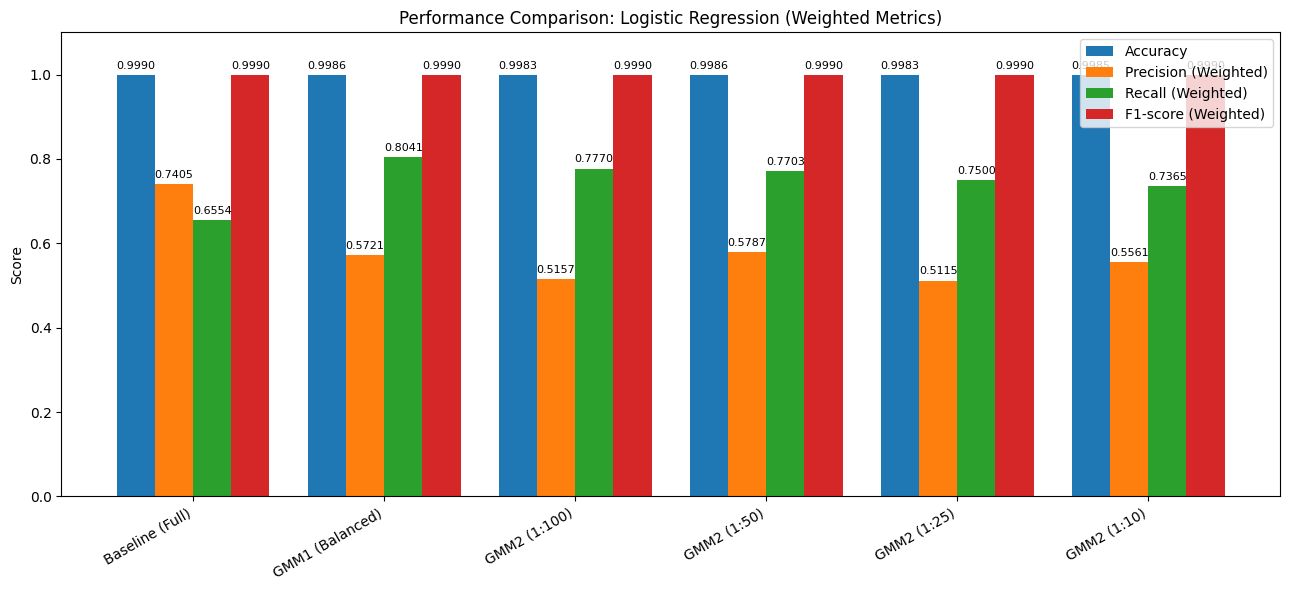

In [108]:
import matplotlib.pyplot as plt
import numpy as np

# Model names
models = [
    "Baseline (Full)",
    "GMM1 (Balanced)",
    "GMM2 (1:100)",
    "GMM2 (1:50)",
    "GMM2 (1:25)",
    "GMM2 (1:10)"
]

# Metrics (weighted versions)
accuracies = [
    metrics3["accuracy"],
    metrics1["accuracy"],
    metrics2_100["accuracy"],
    metrics2_50["accuracy"],
    metrics2_25["accuracy"],
    metrics2_10["accuracy"]
]

precisions_w = [
    metrics3["precision"],
    metrics1["precision"],
    metrics2_100["precision"],
    metrics2_50["precision"],
    metrics2_25["precision"],
    metrics2_10["precision"]
]

recalls_w = [
    metrics3["recall"],
    metrics1["recall"],
    metrics2_100["recall"],
    metrics2_50["recall"],
    metrics2_25["recall"],
    metrics2_10["recall"]
]

f1s_w = [
    metrics3["f1_weighted"],
    metrics1["f1_weighted"],
    metrics2_100["f1_weighted"],
    metrics2_50["f1_weighted"],
    metrics2_25["f1_weighted"],
    metrics2_10["f1_weighted"]
]

# Plot setup
x = np.arange(len(models))
width = 0.2

fig, ax = plt.subplots(figsize=(13,6))
rects1 = ax.bar(x - 1.5*width, accuracies, width, label="Accuracy")
rects2 = ax.bar(x - 0.5*width, precisions_w, width, label="Precision (Weighted)")
rects3 = ax.bar(x + 0.5*width, recalls_w, width, label="Recall (Weighted)")
rects4 = ax.bar(x + 1.5*width, f1s_w, width, label="F1-score (Weighted)")

# Labels and formatting
ax.set_ylabel("Score")
ax.set_title("Performance Comparison: Logistic Regression (Weighted Metrics)")
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=30, ha="right")
ax.legend()
ax.set_ylim(0, 1.1)

# Annotate bars with values
for rects in [rects1, rects2, rects3, rects4]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


# GMM1 is model 1 (GMM based oversampling of minority data to match the number of samples in the majority data).
#GMM2 is model 2 (CBU based undersampling of majority data and oversampling minority data using GMMs to match the number of Majority samples).
# Baseline is the Logistic Regressor trained on just the basic dataset.

As we can see above, setting the threshold higher can have a better performance balancing precision with recall. In our case, the models trained on GMMs are almost identical in performance.

- Baseline has a much lower recal compared to any of the GMM models. It increases by 10-15% using GMMs which is excellent as we are able to get the minority samples predictions more correctly.

- Factors such as Class ratio (majority: minority) seem to play a small role as well. As y increase in (x:y), i.e., the number of majority classes in CBU decreases, the recall tends to fall - this also shows that higher number of majority classes compared to minority is slightly better  (the weighted f1 score doesn't matter much though).

## Reasons why precision could be low:

- The dataspace could be non-linear in nature. So, a logistic regression based model may not be able to perform the classification.

- The best performing model, going by the numbers is the second GMM where CBU is done on the majority sample and oversampling using GMM is done on the minority sample (precision ~ 0.5787 and recall ~ 0.7703). However, the precision needs to be much higher for a "real-life" implemenatations: several factors can improve this, for example by choosing an appropriate classification method.

- The vanilla baseline model has a better precision but lower recall (0.6554). Here, recall is extremely important as we can't ignore a fraudulent transaction which leads me to the fact that GMM based sampling is better. Empirically, CBU undersampling and GMM based oversampling is slightly better as well as CBU just tries to remove datapoints that belong to a majority class cluster.

## Overall, GMM based model have a better recall and precision that can be imporoved using better clustering methods and finetuning them.

In [ ]:
## BONUS

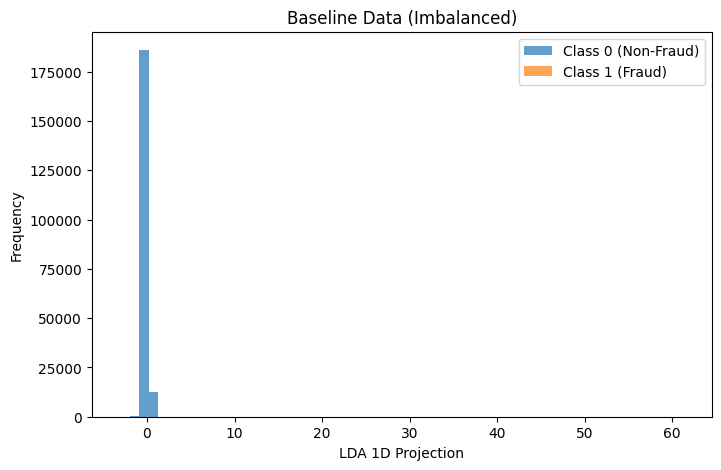

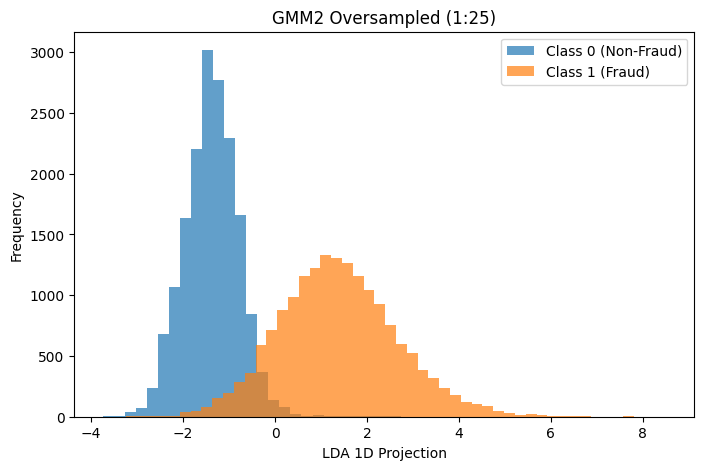

In [111]:
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

def plot_lda_projection(X, y, title="LDA Projection"):
    lda = LDA(n_components=1)
    X_lda = lda.fit_transform(X, y)

    plt.figure(figsize=(8,5))
    plt.hist(X_lda[y==0], bins=50, alpha=0.7, label="Class 0 (Non-Fraud)")
    plt.hist(X_lda[y==1], bins=50, alpha=0.7, label="Class 1 (Fraud)")
    plt.title(title)
    plt.xlabel("LDA 1D Projection")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

# Example: baseline data
plot_lda_projection(X_train, y_train, "Baseline Data (Imbalanced)")

# Example: oversampled GMM data
plot_lda_projection(X_gmm_2_50, y_gmm_2_50, "GMM2 Oversampled (1:50)")

# Example: oversampled GMM data
plot_lda_projection(X_gmm_2_50, y_gmm_2_50, "GMM2 Oversampled (1:50)")


Above plot shows a separation between the representations for the two classes. In initial case, the number of class 1 samples are so small that it is not even visible as a separation. So GMM helps saample points while maintaining separability between the classes.